In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import svd
from sklearn.metrics import root_mean_squared_error

# Step 0: Data Loading and Structural Overview

In [25]:
data = pd.read_csv('data/movielens.csv')
val_idx = pd.read_csv('data/movielens_val_indices.csv')
data_map = pd.read_pickle('data/movie_map.pkl')

In [26]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,0,0,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,2,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,0,4,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,0,23,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,0,25,5.0,964982931,Usual Suspects; The (1995),Crime|Mystery|Thriller


In [27]:
val_idx.head()

,row_inds,col_inds
0,541,743
1,306,387
2,153,958
3,554,649
4,253,719


In [28]:
data_map

{0: 'Toy Story (1995)',
 2: 'Grumpier Old Men (1995)',
 4: 'Heat (1995)',
 23: 'Seven (a.k.a. Se7en) (1995)',
 25: 'Usual Suspects; The (1995)',
 31: 'From Dusk Till Dawn (1996)',
 35: 'Braveheart (1995)',
 42: 'Rob Roy (1995)',
 47: 'Desperado (1995)',
 61: 'Billy Madison (1995)',
 62: 'Clerks (1994)',
 65: 'Dumb & Dumber (Dumb and Dumber) (1994)',
 66: 'Ed Wood (1994)',
 72: 'Star Wars: Episode IV - A New Hope (1977)',
 83: 'Pulp Fiction (1994)',
 87: 'Stargate (1994)',
 92: 'Tommy Boy (1995)',
 99: 'Clear and Present Danger (1994)',
 103: 'Forrest Gump (1994)',
 105: 'Jungle Book; The (1994)',
 107: 'Mask; The (1994)',
 122: 'Dazed and Confused (1993)',
 126: 'Fugitive; The (1993)',
 131: 'Jurassic Park (1993)',
 135: 'Mrs. Doubtfire (1993)',
 140: "Schindler's List (1993)",
 144: 'So I Married an Axe Murderer (1993)',
 146: 'Three Musketeers; The (1993)',
 147: 'Tombstone (1993)',
 154: 'Dances with Wolves (1990)',
 155: 'Batman (1989)',
 156: 'Silence of the Lambs; The (1991)',
 1

In [29]:
print(f'movielens size: {data.shape} - movielens columns: {data.columns}')
print(f'movielens_val_indices size: {val_idx.shape} - movielens_val_indices columns: {val_idx.columns}')
print(f'data_map size: {len(data_map)}, data_map type: {type(data_map)}')

movielens size: (62518, 6) - movielens columns: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')
movielens_val_indices size: (6252, 2) - movielens_val_indices columns: Index(['row_inds', 'col_inds'], dtype='object')
data_map size: 1050, data_map type: <class 'dict'>


# Step 1: Construct the Rating Matrix and Validation Split

## Build rating matrix A

In [44]:
num_users = data["userId"].nunique()
num_movies = len(data_map)

A_df = data[['userId', 'movieId', 'rating']]

A = np.zeros((num_users, num_movies))
for _, row in A_df.iterrows():
    A[int(row["userId"]), int(row["movieId"])] = row["rating"]

In [46]:
print("A shape:", A.shape)
print("A nonzeros:", np.count_nonzero(A))
print("A sum:", A.sum())

A shape: (610, 1050)
A nonzeros: 62518
A sum: 227818.5


In [49]:
A[:5]

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

## Validation split

In [51]:
rows = val_idx["row_inds"].values
cols = val_idx["col_inds"].values

A_fit = A.copy()
y_val_true = A[rows, cols]
A_fit[rows, cols] = 0

In [53]:
print("All validation entries zeroed:",
      np.all(A_fit[rows, cols] == 0))

print("A_fit sum:", A_fit.sum())

print("y_val_true (first 5 samples):", y_val_true[:5])
print("y_val_true (last 5 samples):", y_val_true[-5:])

All validation entries zeroed: True
A_fit sum: 205049.0
y_val_true (first 5 samples): [4.  2.  5.  3.  4.5]
y_val_true (last 5 samples): [4. 3. 3. 3. 4.]


# Step 2: Data Imputation

## fill-zero

In [55]:
A_fit_zero = A_fit

## fill-mean

In [59]:
global_mean = A_fit[A_fit != 0].mean()
A_fit_mean = A_fit.copy()

num_users, num_movies = A_fit_mean.shape
for u_idx in range(num_users):
    user_ratings = A_fit_mean[u_idx, :]
    nonzero_mask = (user_ratings != 0)

    if np.any(nonzero_mask):
        user_mean = user_ratings[nonzero_mask].mean()
    else:
        user_mean = global_mean

    A_fit_mean[u_idx, ~nonzero_mask] = user_mean


print("A_fit_mean shape:", A_fit_mean.shape)
print("A_fit_mean nonzeros:", np.count_nonzero(A_fit_mean))
print("A_fit_mean sum:", A_fit_mean.sum())
print('Global Mean:', global_mean)

A_fit_mean shape: (610, 1050)
A_fit_mean nonzeros: 640500
A_fit_mean sum: 2384086.2986536995
Global Mean: 3.6442789606511927


In [61]:
A_fit_mean[:5]

array([[4.        , 4.4       , 4.        , ..., 4.4       , 4.4       ,
        4.4       ],
       [3.90909091, 3.90909091, 3.90909091, ..., 3.90909091, 3.90909091,
        3.90909091],
       [1.73684211, 1.73684211, 1.73684211, ..., 1.73684211, 1.73684211,
        1.73684211],
       [3.55263158, 3.55263158, 3.55263158, ..., 3.55263158, 3.55263158,
        3.55263158],
       [4.        , 3.56756757, 3.56756757, ..., 3.56756757, 3.56756757,
        3.56756757]])

# Step 3: SVD Reconstruction and Validation RMSE

## Reconstruction with fill-zero

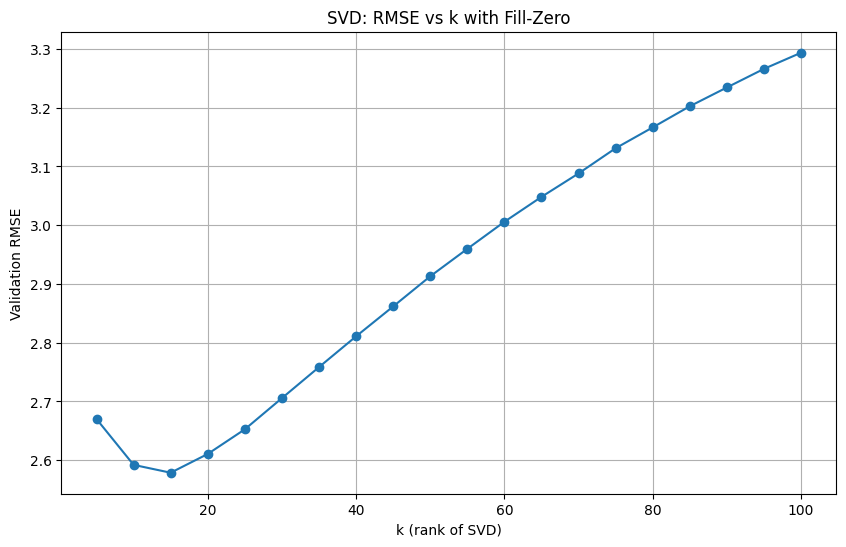

In [84]:
val_rows = val_idx["row_inds"].values
val_cols = val_idx["col_inds"].values

U, s, VT = svd(A_fit_zero, full_matrices=False)
k_values = list(range(5, 101, 5))

rmse_results_zero = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]

    A_hat = Uk @ Sk @ Vk

    pred = A_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_results_zero.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_results_zero, marker='o', label='A_fit zeros')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation RMSE")
plt.title("SVD: RMSE vs k with Fill-Zero")
plt.grid(True)
plt.show()

## Reconstruction with Fill-Mean

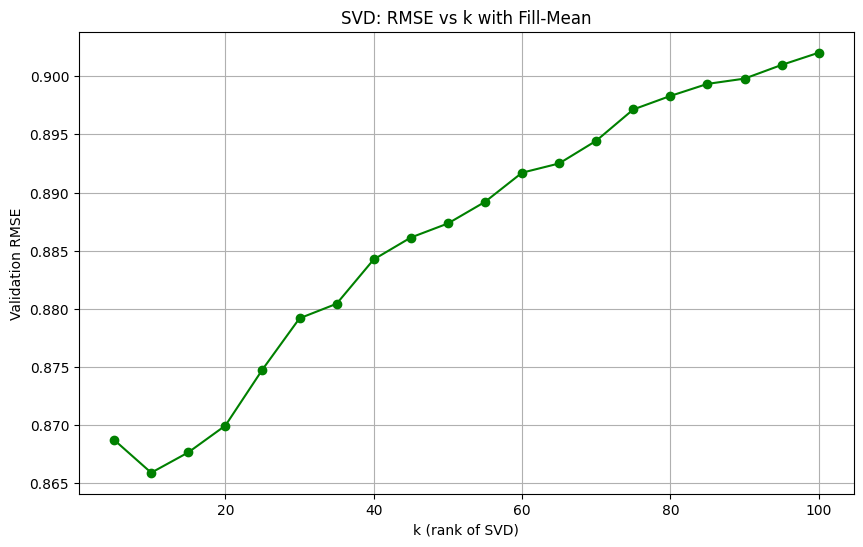

In [86]:
U, s, VT = svd(A_fit_mean, full_matrices=False)
k_values = list(range(5, 101, 5))

rmse_results_mean = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]

    A_hat = Uk @ Sk @ Vk

    pred = A_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_results_mean.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_results_mean, marker='o', color='green', label='A_fit Mean')

plt.xlabel("k (rank of SVD)")
plt.ylabel("Validation RMSE")
plt.title("SVD: RMSE vs k with Fill-Mean")
plt.grid(True)
plt.show()

# Step 4:

## PCA for A_fit_zero (zeros for missing)

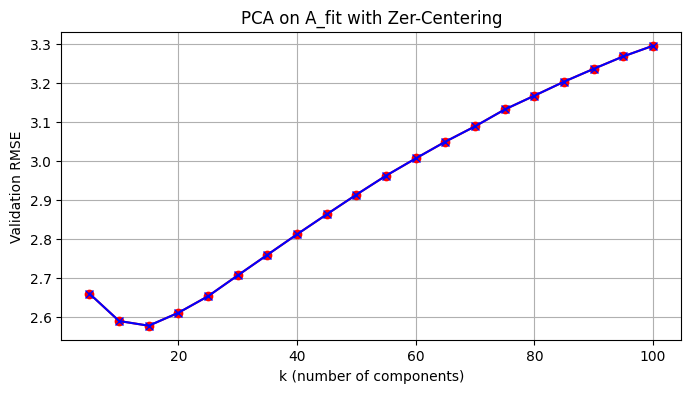

In [95]:
val_rows = val_idx["row_inds"].values
val_cols = val_idx["col_inds"].values

k_values = list(range(5, 101, 5))

# center by column
col_mean = A_fit_zero.mean(axis=0)
A_zero_centered = A_fit_zero - col_mean

# PCA via Covariance
cov_mat = np.cov(A_zero_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_mat)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

rmse_cov_zero = []
for k in k_values:
    V_k = eigvecs[:, :k]
    A_pred = (A_zero_centered @ V_k @ V_k.T) + col_mean

    pred = A_pred[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_cov_zero.append(rmse)


# PCA via SVD
col_mean = A_fit_zero.mean(axis=0)
A_zero_centered = A_fit_zero - col_mean
U, s, VT = np.linalg.svd(A_zero_centered, full_matrices=False)

rmse_svd_zero = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]
    A_pred = (Uk @ Sk @ Vk) + col_mean

    pred = A_pred[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_svd_zero.append(rmse)


plt.figure(figsize=(8,4))
plt.plot(k_values, rmse_cov_zero, marker='o', color='red', label='A_fit_zero PCA(cov)')
plt.plot(k_values, rmse_svd_zero, marker='x', color='blue', label='A_fit_zero PCA(SVD)')
plt.xlabel("k (number of components)")
plt.ylabel("Validation RMSE")
plt.title("PCA on A_fit with Zer-Centering")
plt.grid(True)
plt.show()

## PCA for A_fit_mean (user-mean filled)

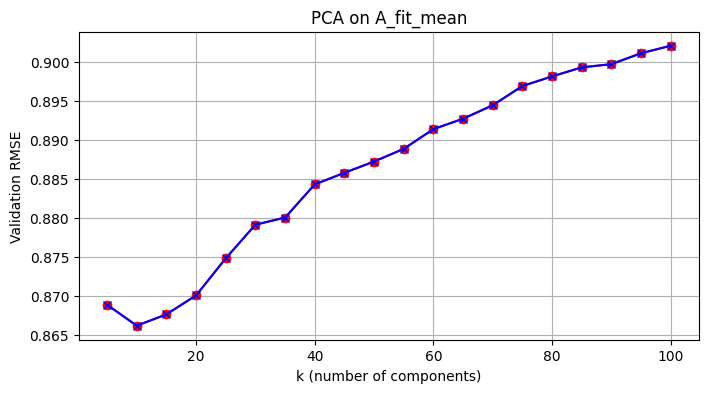

In [96]:
# PCA via Covariance
col_mean = A_fit_mean.mean(axis=0)
M_centered = A_fit_mean - col_mean

cov_mat = np.cov(M_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_mat)
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

rmse_cov_mean = []
for k in k_values:
    V_k = eigvecs[:, :k]
    M_hat = (M_centered @ V_k @ V_k.T) + col_mean

    pred = M_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_cov_mean.append(rmse)


# PCA via SVD
col_mean = A_fit_mean.mean(axis=0)
M_centered = A_fit_mean - col_mean
U, s, VT = np.linalg.svd(M_centered, full_matrices=False)

rmse_svd_mean = []
for k in k_values:
    Uk = U[:, :k]
    Sk = np.diag(s[:k])
    Vk = VT[:k, :]
    M_hat = (Uk @ Sk @ Vk) + col_mean

    pred = M_hat[val_rows, val_cols]
    true = A[val_rows, val_cols]
    rmse = root_mean_squared_error(true, pred)
    rmse_svd_mean.append(rmse)

plt.figure(figsize=(8, 4))
plt.plot(k_values, rmse_cov_mean, marker='o', color='red', label='B_user_mean PCA(cov)')
plt.plot(k_values, rmse_svd_mean, marker='x', color='blue', label='B_user_mean PCA(SVD)')
plt.xlabel("k (number of components)")
plt.ylabel("Validation RMSE")
plt.title("PCA on A_fit_mean")
plt.grid(True)
plt.show()